In [1]:
import sys
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from torch.optim import Adam

from simdata import  fdd, pdeinp, icinp, bcinp,HT_sim ,scaler, invscaler
from loss_func import loss_fn_data,pde_loss,ic_loss,boundary_loss
from train_testloop import training_loop

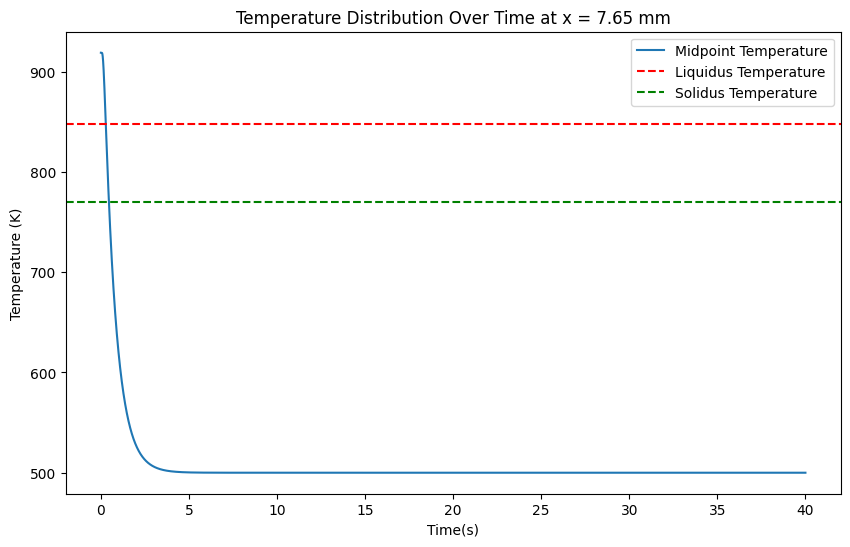

0.0003061224489795918
0.0012711033647622566


In [2]:
# The simulation data is generated using the datagen function in simdata.py
# the data solves 1D heat equation with dirichlet boundary conditions

length = 15e-3
time_end = 40.0
numpoints = 50
temp_init = 919.0
t_surr = 500.0

heat_data = HT_sim(length, time_end, numpoints,  t_surr,temp_init)
alpha = heat_data.alpha_l
tempfield = heat_data.datagen()

heat_data.plot_temp(25)

print(heat_data.dx)
print(heat_data.dt)


In [3]:
# Parameters
L = length       # Rod length
alpha = alpha # Thermal diffusivity
num_times = time_end//heat_data.dt  # Number of time snapshots

t_vals = np.linspace(0,time_end,int(num_times))  # Time snapshots
x = np.linspace(0, L, numpoints)

# Compute the solution
def heat_solution(x, t, alpha):
    return np.exp(-alpha * np.pi**2 * t) * np.sin(np.pi * x)

y_true = np.zeros((len(t_vals), len(x)))
print(y_true.shape)

for i, t in enumerate(t_vals):
    for j, xi in enumerate(x):
        y_true[i, j] = heat_solution(xi, t, alpha)

print(y_true.shape)


(31468, 50)
(31468, 50)


In [4]:
import torch

# Define expected solution u(x,t) = exp(-t) * sin(pi*x)
def exact_solution(x, t):
    return torch.exp(-t) * torch.sin(torch.pi * x)

# Compute derivatives using autograd
def compute_autograd_residual(x, t, alpha=alpha):
    x.requires_grad = True
    t.requires_grad = True

    u = exact_solution(x, t)

    # Compute first derivative wrt t
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]

    # Compute first and second derivatives wrt x
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

    # Compute PDE residual
    pde_residual = u_t - alpha * u_xx

    return u_t, u_xx, pde_residual

# Test at a sample point
x_test = torch.tensor([[25]], dtype=torch.float32, requires_grad=True)
t_test = torch.tensor([[10]], dtype=torch.float32, requires_grad=True)
alpha = alpha

# Compute autograd derivatives
u_t_autograd, u_xx_autograd, residual_autograd = compute_autograd_residual(x_test, t_test, alpha)

# Compute analytical derivatives
u_t_exact = -torch.exp(-t_test) * torch.sin(torch.pi * x_test)
u_xx_exact = -torch.pi**2 * torch.exp(-t_test) * torch.sin(torch.pi * x_test)
residual_exact = u_t_exact - alpha * u_xx_exact

# Print and compare results
print(f"Autograd ∂u/∂t: {u_t_autograd.item()}, Exact ∂u/∂t: {u_t_exact.item()}")
print(f"Autograd ∂²u/∂x²: {u_xx_autograd.item()}, Exact ∂²u/∂x²: {u_xx_exact.item()}")
print(f"Autograd Residual: {residual_autograd.item()}, Exact Residual: {residual_exact.item()}")

Autograd ∂u/∂t: 6.675214547779973e-11, Exact ∂u/∂t: 6.675214547779973e-11
Autograd ∂²u/∂x²: 6.588173340205117e-10, Exact ∂²u/∂x²: 6.588172229982092e-10
Autograd Residual: 6.672978142274744e-11, Exact Residual: 6.672978142274744e-11


In [7]:
m = np.linspace(0, 15e-3, 10)
n = np.linspace(0, 5, 10)
x = torch.tensor(m, dtype=torch.float32, requires_grad=True)
t = torch.tensor(n, dtype=torch.float32, requires_grad=True)  
def cos(x):
    return torch.cos(x)

y = t* cos(x)

real = cos(x)+ t*cos(x)       
pde = pde_loss(y, x, t,1, 1)

print(pde)  
print(real)

tensor([1.0000, 1.5556, 2.1111, 2.6666, 3.2222, 3.7776, 4.3331, 4.8886, 5.4440,
        5.9993], grad_fn=<SubBackward0>)
tensor([1.0000, 1.5556, 2.1111, 2.6666, 3.2222, 3.7776, 4.3331, 4.8886, 5.4440,
        5.9993], grad_fn=<AddBackward0>)
